<a href="https://colab.research.google.com/github/carlotatrx/advent_coders_2024/blob/master/Advanced_scikit_learn_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This course is designed to guide students in building complete end to end studies involving Machine learning based tools.


* Data inspection with non-linear embedding
* Probabililistic gaussian clustering
* K means - cluster number selection and metric selection
* Clustering discrete data
* Data Normalization
* Data imputation
* Pipelines
* Data IO
* Visualization techniques and interactive visualizations


# Advanced ML with scikit-learn
<p>
Bern, 2025<br>
Prepared by Dr. Mykhailo Vladymyrov and Matteo Boi.
</p>

This work is licensed under a <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.


We focus here not as much on the tools used, as on the way of thinking, and approaching the task at hand.

# Imports and utils

If you work on Colab, you can install the packages with `!pip install package_name`:


In [1]:
!pip install dash hdbscan impyute kmodes pyod umap-learn > /dev/null

If you work on your local machine, please run your [miniforge](https://github.com/conda-forge/miniforge) or [miniconda](https://docs.conda.io/en/latest/miniconda.html) environment and install the packages like this:

```bash
conda install dash hdbscan kmodes plotly pyod umap-learn
```

Some packages may not be installable through conda, but you can usually install them with pip:

```bash
pip install impyute
```

To export the environment to a file, you can run:

```bash
conda env export > environment.yml
```

While to create the environment from the file:

```bash
conda env create -f environment.yml
```

In [2]:
import os
import requests
import tarfile

import pandas as pd
import numpy as np

from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors

# dimensionality reduction
import umap
from sklearn.decomposition import PCA

# clustering kmeans, gaussian
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from sklearn.mixture import GaussianMixture
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

# metrics for clustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# classification report and metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
# confusion matrix display
from sklearn.metrics import ConfusionMatrixDisplay

#regression metrics:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# preprocessing
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# imputations
from pyod.models.ecod import ECOD

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from impyute.imputation.cs import mice
from sklearn.base import BaseEstimator, TransformerMixin

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

# a model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# dataset
from sklearn.datasets import fetch_california_housing

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dash import Dash, html, dcc, Input, Output, callback

# utils
from tqdm.auto import tqdm
from joblib import dump, load

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Step 0: study your data

The first step in any data analysis is to study the data. You are the domain expert, and you know your data the best. Yet there are always ways to see the data from a different angle, and to get a better understanding of it.

Furthermore, the data might be corrupted, or have missing values, or be in a format that is not suitable for the task at hand.
Thus, the first step is to inspect the data yourself, and ensure it is apropriate.

## First inspection

In [3]:
# load house prices dataset

data = fetch_california_housing(as_frame=True) # as_frame=True
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])


In [4]:
print(data.DESCR)
print(data.feature_names)
print(data.target_names)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
x, y = np.array(data.data), np.array(data.target)

In [6]:
print(x.shape, y.shape)

(20640, 8) (20640,)


As reminder:

<img src="https://github.com/dsl-unibe-ch/Advanced_ML_with_scikit-learn/raw/main/xy.png" alt="fig_feature" width="110%"/><br>


In [10]:
df = data.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We can now check more into details the data types and if the dataset contains any missing value.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


There is no missing values. Good.

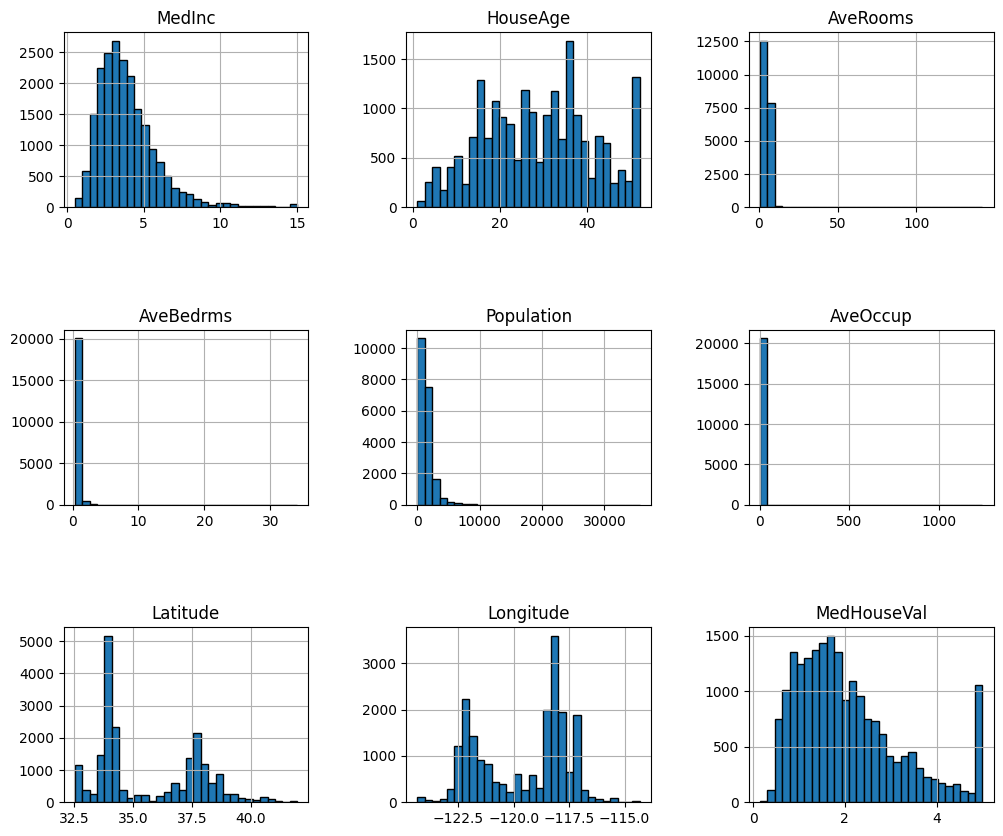

In [14]:
df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

We can start by analyzing features whose distributions align with expectations.  

The **median income** shows a distribution with a long tail. This indicates that most incomes follow a roughly normal distribution, but there are a few individuals earning significantly higher salaries.  

The **average house age** appears to follow a nearly uniform distribution.  

The target variable also has a long-tail distribution. Additionally, there is a threshold effect for high-valued houses—any house priced above 5 is capped at a value of 5.  

Looking at **average rooms, average bedrooms, average occupancy**, and **population**, these features span a wide range of values. The bins for the largest values are barely noticeable, suggesting the presence of a few extremely high values that might be outliers. This becomes clearer when we examine the summary statistics for these features.

In [15]:
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
df[features_of_interest].describe().T

,count,mean,std,min,25%,50%,75%,max
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000


For each of these features, the large gap between the **maximum** and **75th percentile** values highlights the presence of a few extreme values, confirming our initial intuition.  

So far, we haven’t explored **longitude** and **latitude**, which provide geographical information. These features could help us identify whether certain locations are associated with high-priced houses. To do this, we could create a scatter plot with *latitude* and *longitude* on the x- and y-axes, while using the circle size and color to represent house values in each district.

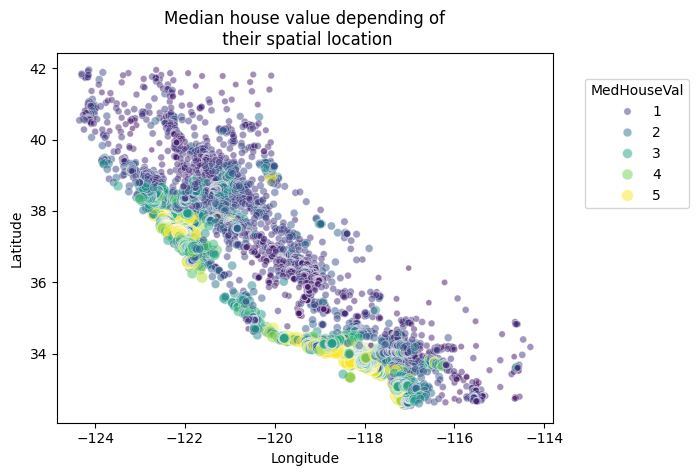

In [16]:
sns.scatterplot(
    data=df,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

If you’re unfamiliar with California, it’s worth noting that the data points outline the state’s geographical shape. High-priced houses are predominantly located along the coast, where California’s major cities (San Diego, Los Angeles, San Jose, and San Francisco) are situated.

We can also create a *pairplot*, which visualizes pairwise relationships between multiple features in a grid of scatter plots. This allows us to observe how features interact with each other and helps identify potential patterns, correlations, or outliers. For example, a pairplot can reveal how house prices relate to variables like median income, house age, or population. It’s particularly useful for quickly spotting trends and understanding the overall structure of the dataset.

In [24]:
%%time
# Drop the unwanted columns
columns_drop = ["Longitude", "Latitude"]
subset = df.drop(columns=columns_drop)

CPU times: user 3.38 ms, sys: 0 ns, total: 3.38 ms
Wall time: 4.21 ms


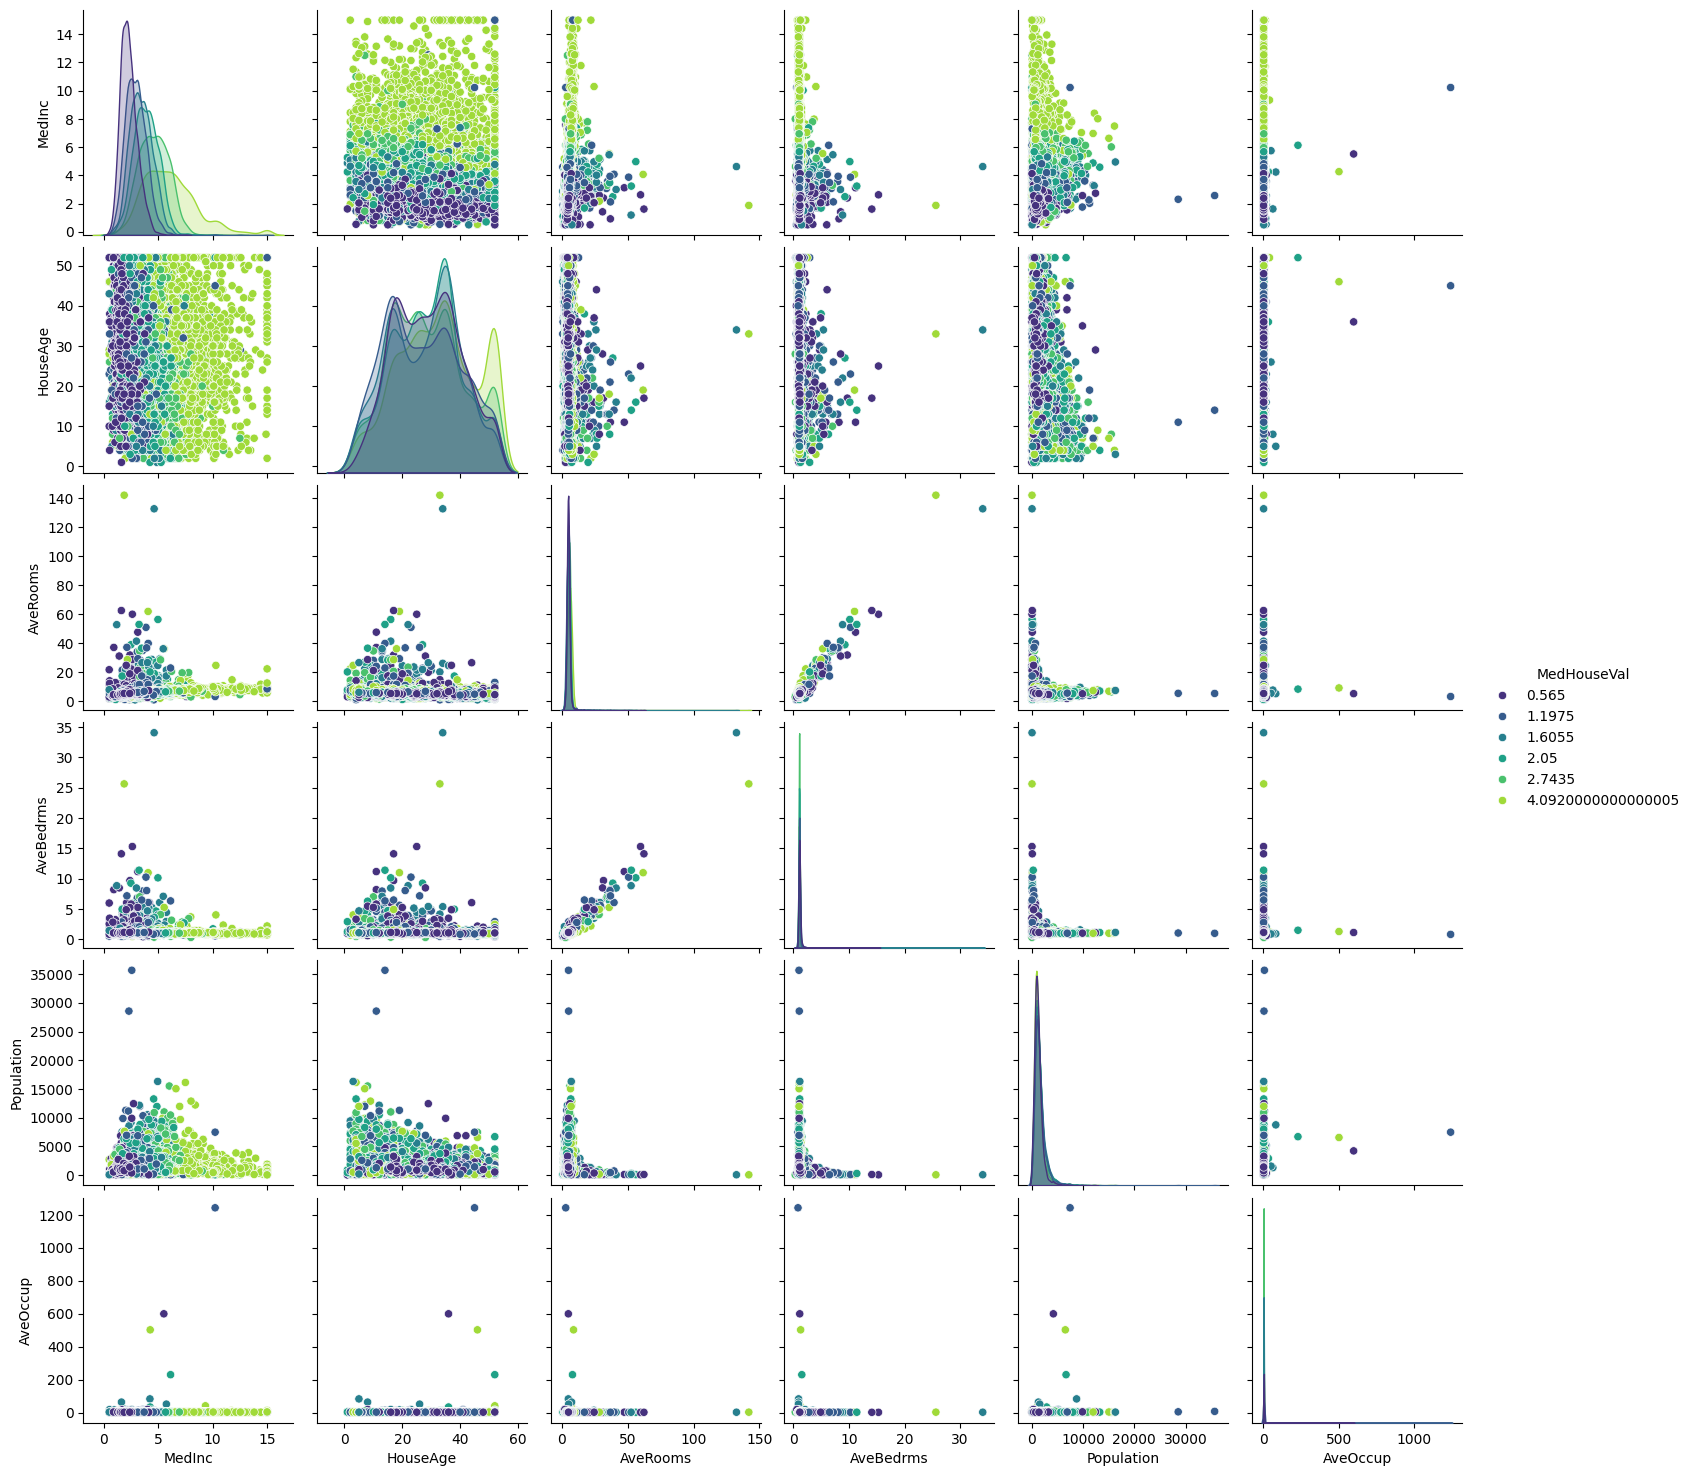

In [25]:
# Quantize the target and keep the midpoint for each interval
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)

_ = sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis")

In this case, `pd.qcut` divides MedHouseVal into six quantiles, assigning each interval a midpoint for easier plotting and interpretation.

Interpreting a pairplot can be challenging due to the large amount of data, but it still offers some valuable insights. We can clearly identify extreme values (potential outliers) in several features. Additionally, it becomes evident that *median income* is a strong indicator for distinguishing high-valued houses from lower-valued ones.

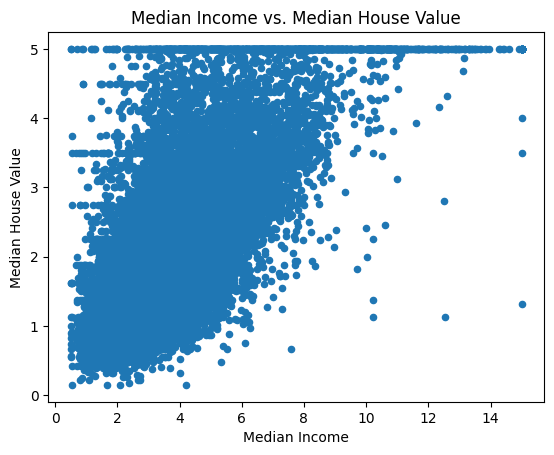

In [26]:
df.plot(kind="scatter", x="MedInc", y="MedHouseVal")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Median Income vs. Median House Value")
plt.show()

The plot above reveals a strong linear correlation between **Median Income** and **House Value**. Additionally, the House Value capped at 5 appears again, forming distinct horizontal lines. This could pose issues for modeling and should be addressed through preprocessing.

Therefore, when building a predictive model, we can expect *longitude*, *latitude*, and *median income* to be important features for predicting *median house values*.

However, in the dense areas there are so many points, that we can't really see the distribution. We can use the Kernel Density Estimation (KDE) plot.

### Kernel Density Estimation (KDE)

Subsampled data shape: (2064, 7)


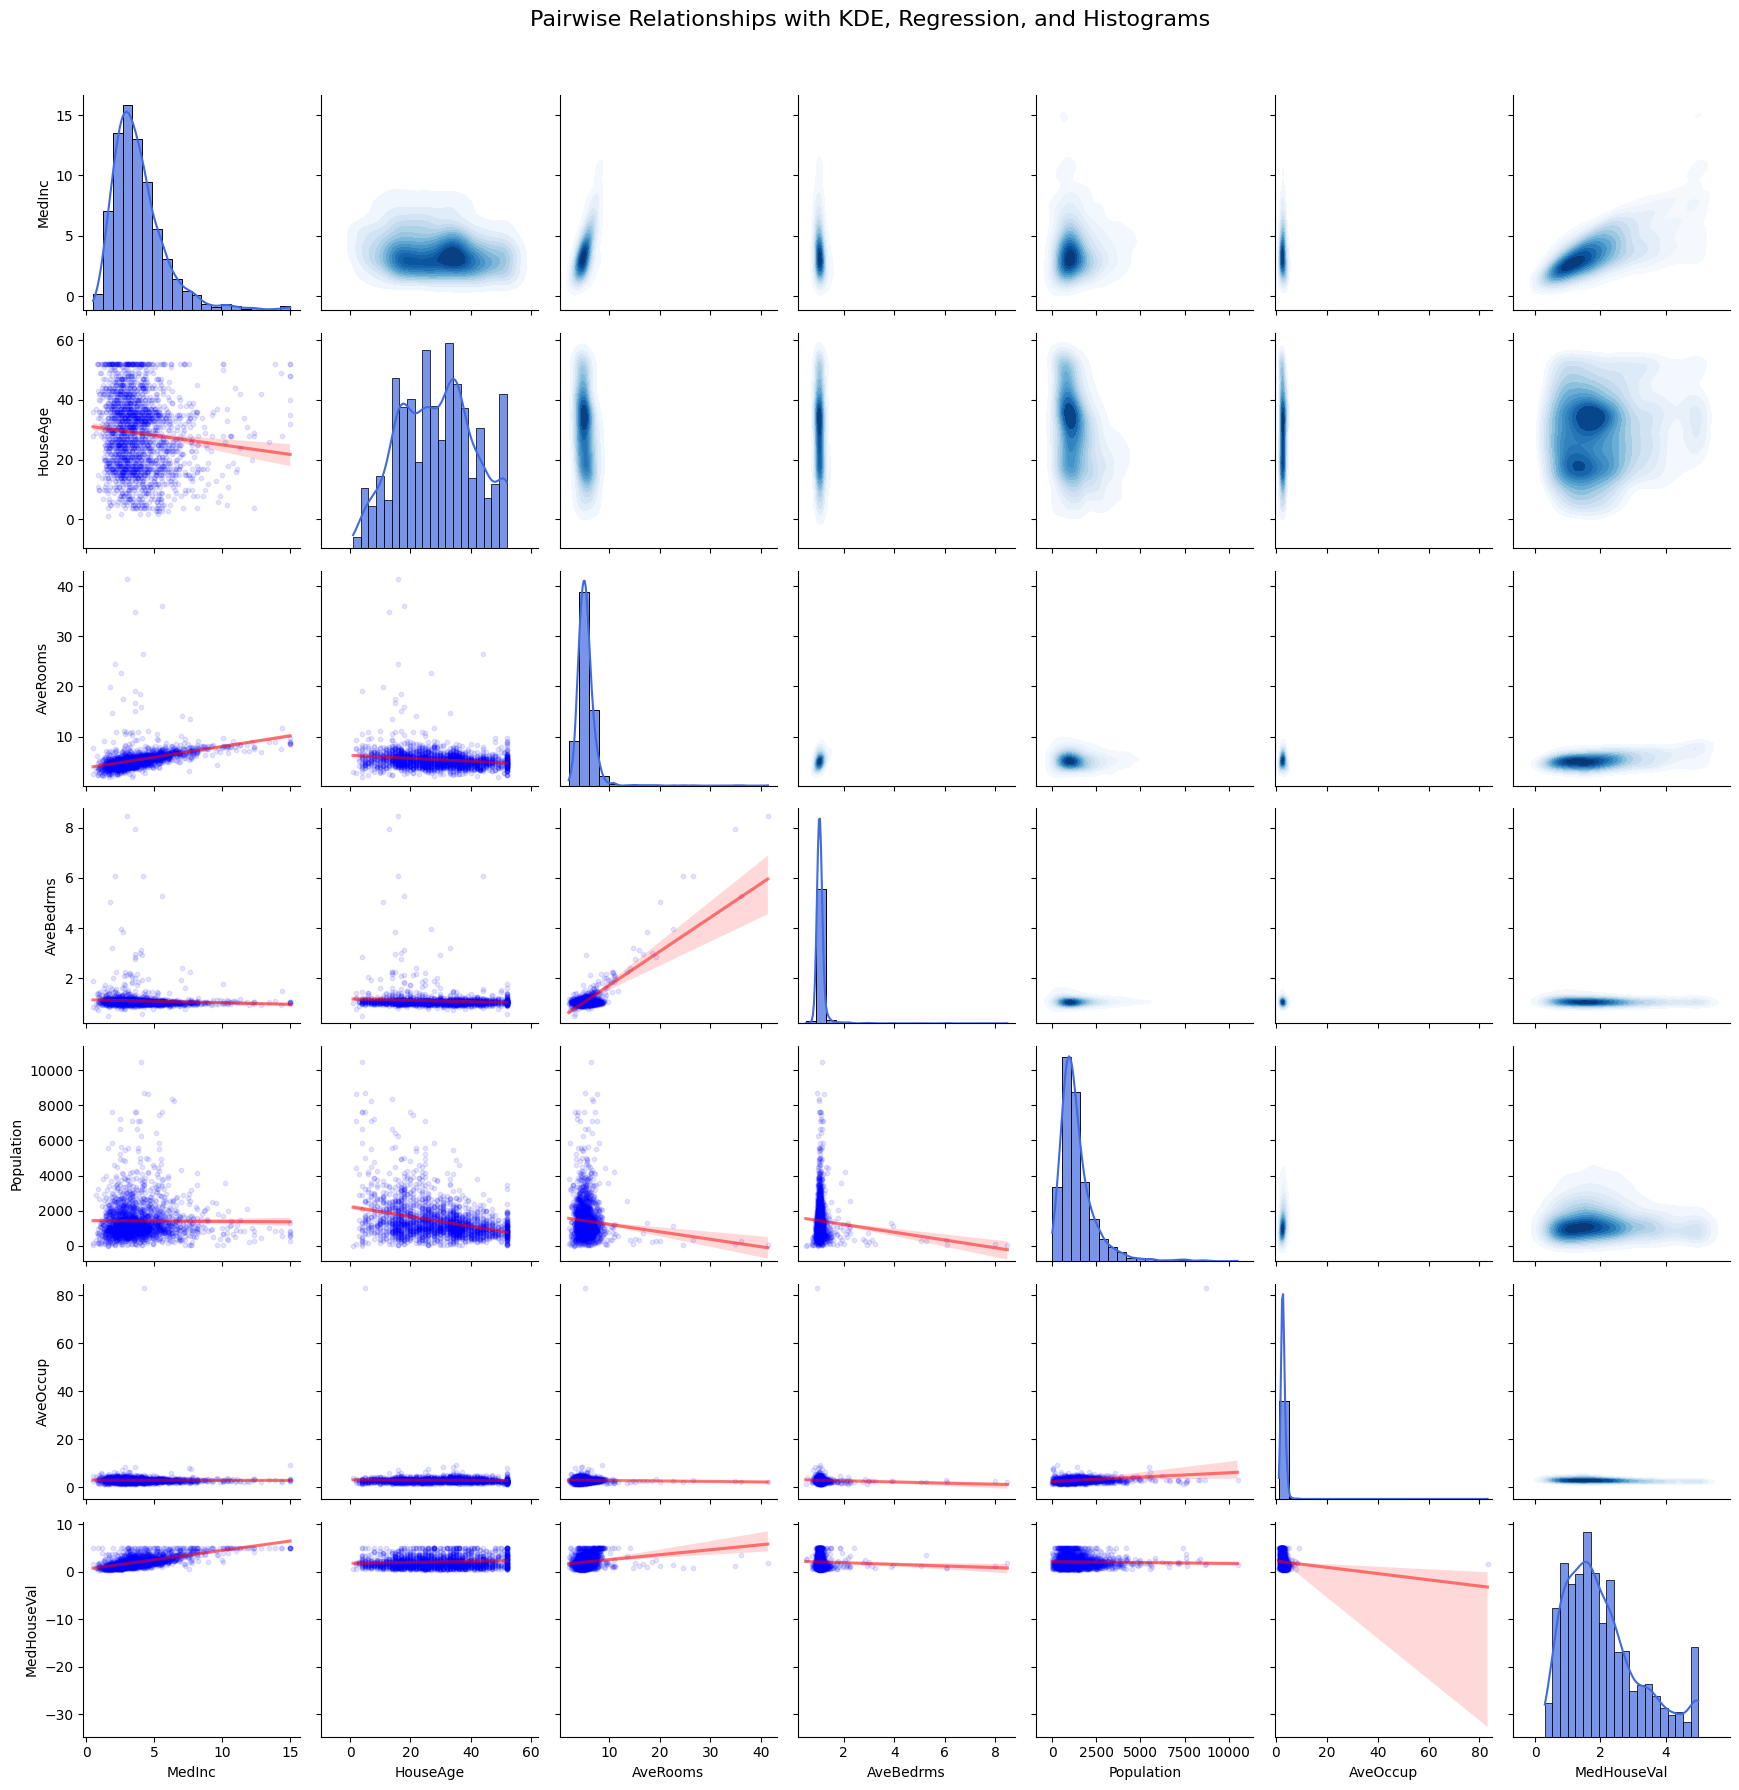

In [27]:
# Subsample the data to 10% to reduce computation time
subset = df.sample(frac=0.1, random_state=42).drop(columns=columns_drop)
print(f"Subsampled data shape: {subset.shape}")

# Create a PairGrid
g = sns.PairGrid(subset, diag_sharey=False, height=2.5)

# KDE plot on the upper triangle
g.map_upper(sns.kdeplot, cmap='Blues', n_levels=15, fill=True)

# Scatter plot on the lower triangle with a regression line
g.map_lower(
    sns.regplot,
    scatter_kws={'color': 'blue', 'alpha': 0.1, 's': 10},
    line_kws={'color': 'red', 'alpha': 0.5}
)

# Histogram on the diagonal
g.map_diag(sns.histplot, kde=True, color='royalblue', alpha=0.7, bins=20)

# Improve the aesthetics
g.fig.suptitle("Pairwise Relationships with KDE, Regression, and Histograms", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

**KDE Plots:** In the upper triangle of the pair grid, we are plotting the Kernel Density Estimation (KDE) to visualize the distribution of features. The KDE plots help us observe the density and underlying structure of the data, which is particularly useful in identifying clusters or regions of higher data concentration. The color gradient in these plots represents the density levels, with darker shades indicating higher concentrations of data points. We set `n_levels=15` to provide a finer resolution of the density contours.

**Scatter Plots with Regression Lines:** In the lower triangle, we display scatter plots with regression lines to highlight the relationships between feature pairs. The scatter plot points are semi-transparent (`alpha=0.1`), allowing us to better see areas with high data concentration without overcrowding. The red regression line (`alpha=0.5`) indicates the general trend or linear relationship between the variables.

**Histograms with KDE on Diagonal:** On the diagonal, histograms show the distribution of each feature, with a Kernel Density Estimate (KDE) overlaid. The KDE provides a smoother, continuous estimate of the feature distribution, helping us understand how data points are distributed across the feature’s range. The `bins=20` parameter ensures a reasonable level of granularity.


### Principal Component Analysis (PCA)

While KDE plots provide us with insight into the density and relationships in the data, they do not necessarily reveal the underlying structure in terms of how the features contribute to variance in the dataset. PCA, on the other hand, helps us reduce the dimensionality of the dataset by transforming the features into a smaller set of components that explain the maximum variance. This can reveal the most important patterns and relationships that may not be immediately apparent in the raw data.

Using PCA, we can project the data onto a new set of axes, called **principal components**, which capture the most significant sources of variation in the data. This allows us to visualize the data in lower-dimensional space and identify potential clusters or trends that may be obscured by the complexity of high-dimensional data.

In [28]:
# Same number of components as the original data
n_components = x.shape[1]

# Apply PCA to the data
pca = PCA(n_components=n_components)  # Reduce to 2 components for 2D visualization
x_pca = pca.fit_transform(x)

print(x_pca.shape)

(20640, 8)


In [32]:
# Explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio:\n {explained_variance}")

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)
print(f"\nCumulative Explained Variance:\n {cumulative_explained_variance}")

Explained Variance Ratio:
 [9.99789327e-01 1.13281110e-04 8.32834638e-05 6.44304641e-06
 5.12871119e-06 2.31833048e-06 1.94839669e-07 2.37222570e-08]

Cumulative Explained Variance:
 [0.99978933 0.99990261 0.99998589 0.99999233 0.99999746 0.99999978
 0.99999998 1.        ]


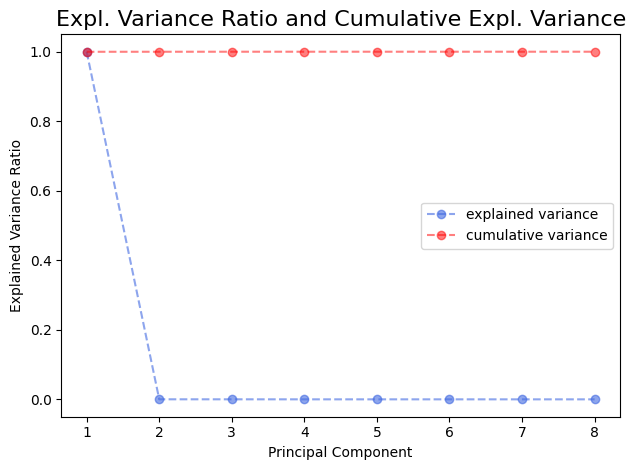

In [33]:
# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance) + 1), explained_variance, color='royalblue', marker='o', linestyle='--', alpha=0.6, label="explained variance")
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='red', marker='o', linestyle='--', alpha=0.5, label="cumulative variance")
plt.title('Expl. Variance Ratio and Cumulative Expl. Variance', fontsize=16)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.tight_layout()
plt.legend()
plt.show()

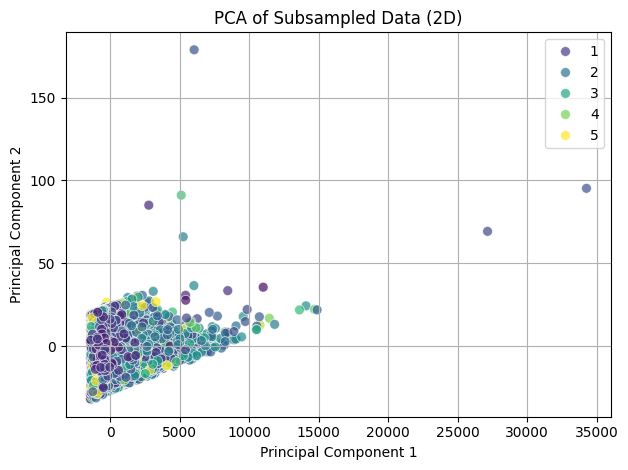

In [34]:
# Plot the PCA results
sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], palette='viridis', s=50, alpha=0.7, hue=y)
plt.title('PCA of Subsampled Data (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

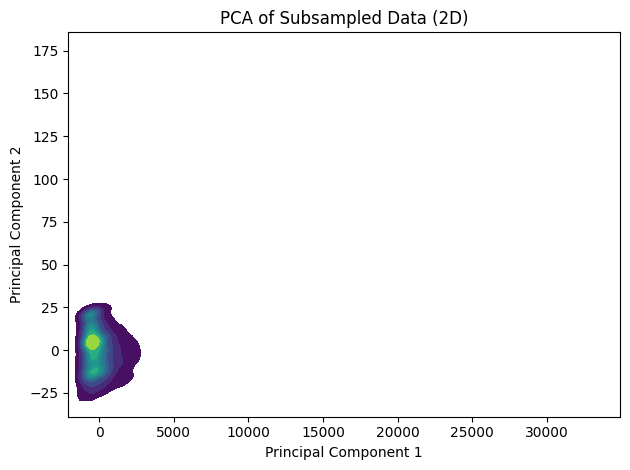

In [37]:
# Let's visualize the distribution density with KDE (again, it takes a long time. We could subsample.)

sns.kdeplot(x=x_pca[:, 0], y=x_pca[:, 1], cmap='viridis', n_levels=10, fill=True) # n_levels=5, fill=False,
plt.title('PCA of Subsampled Data (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

In [38]:
# Let's now visualize the third dimension too.

fig = px.scatter_3d(x=x_pca[:, 0], y=x_pca[:, 1], z=x_pca[:, 2],
                    title="3D Scatter Plot of PCA (First 3 Components)",
                    labels={'PC1': 'Principal Component 1',
                            'PC2': 'Principal Component 2',
                            'PC3': 'Principal Component 3'},
                    color=y,
                    color_continuous_scale='Viridis',
                    opacity=0.7)

fig.update_traces(marker=dict(size=3))
fig.update_layout(width=1000, height=800)
fig.show()

What do you notice about the data, especially in the last two plots?

Do you see anything odd?

In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


**Features with Large Variance Dominate**

PCA identifies the directions with the highest variance. If some features have much larger values or variances than others (e.g., population), they will dominate the principal components. This causes the PCA to focus primarily on these high-magnitude features, ignoring those with smaller magnitudes.

## Standardization

In [40]:
x_orig = x.copy()
y_orig = y.copy()

In [41]:
# Standardize the features before applying PCA
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x = scaler_x.fit_transform(x_orig)
y = scaler_y.fit_transform(y_orig.reshape(-1, 1)).reshape(-1)

In [42]:
# Print normalization coefficients
print("Normalization Coefficients:\n")

print("X-axis Feature:")
print(f"  Mean: {scaler_x.mean_}")
print(f"\n  Variance: {scaler_x.var_}\n")

print("Y-axis Feature:")
print(f"  Mean: {scaler_y.mean_}")
print(f"  Variance: {scaler_y.var_}")

Normalization Coefficients:

X-axis Feature:
  Mean: [ 3.87067100e+00  2.86394864e+01  5.42899974e+00  1.09667515e+00
  1.42547674e+03  3.07065516e+00  3.56318614e+01 -1.19569704e+02]

  Variance: [3.60914769e+00 1.58388586e+02 6.12123614e+00 2.24580619e-01
 1.28240832e+06 1.07864799e+02 4.56207160e+00 4.01394488e+00]

Y-axis Feature:
  Mean: [2.06855817]
  Variance: [1.3315503]


In [43]:
print(x.var(axis=0)) # variance per features
print(y.var())

[1. 1. 1. 1. 1. 1. 1. 1.]
1.0


You can always perform the inverse transformation to check if it is correct

In [44]:
x_inv = scaler_x.inverse_transform(x)
y_inv = scaler_y.inverse_transform(y.reshape(-1, 1)).reshape(-1)

print(x_inv.mean(axis=0), x_inv.var(axis=0))
print(y_inv.mean(), y_inv.var())

[ 3.87067100e+00  2.86394864e+01  5.42899974e+00  1.09667515e+00
  1.42547674e+03  3.07065516e+00  3.56318614e+01 -1.19569704e+02] [3.60914769e+00 1.58388586e+02 6.12123614e+00 2.24580619e-01
 1.28240832e+06 1.07864799e+02 4.56207160e+00 4.01394488e+00]
2.068558169089147 1.3315503000818076


And compare it with mean and variance of the original data

In [45]:
print(x_orig.mean(axis=0), x_orig.var(axis=0))
print(y_orig.mean(), y_orig.var())

[ 3.87067100e+00  2.86394864e+01  5.42899974e+00  1.09667515e+00
  1.42547674e+03  3.07065516e+00  3.56318614e+01 -1.19569704e+02] [3.60914769e+00 1.58388586e+02 6.12123614e+00 2.24580619e-01
 1.28240832e+06 1.07864799e+02 4.56207160e+00 4.01394488e+00]
2.068558169089147 1.3315503000818076


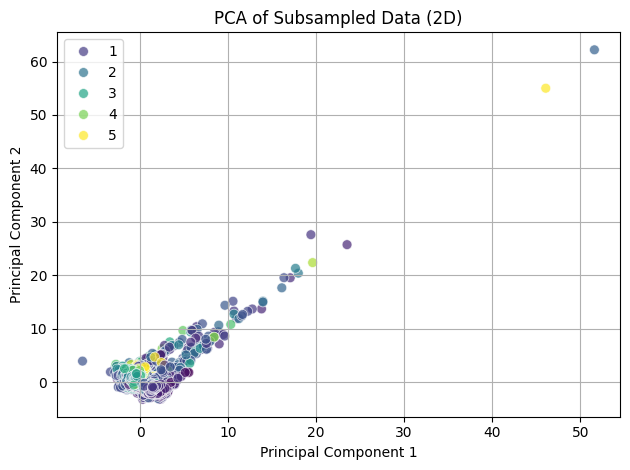

In [46]:
# PCA on the standardized data
pca = PCA(n_components=8)  # Reduce to 2 components for 2D visualization
x_pca_standardized = pca.fit_transform(x)

sns.scatterplot(x=x_pca_standardized[:, 0], y=x_pca_standardized[:, 1], palette='viridis', s=50, alpha=0.7, hue=y_orig)
plt.title('PCA of Subsampled Data (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

Explained Variance Ratio:
 [0.25336868 0.23516245 0.15888635 0.12887971 0.12538195 0.0824225
 0.01020022 0.00569814]

Cumulative Explained Variance:
 [0.25336868 0.48853113 0.64741747 0.77629718 0.90167913 0.98410164
 0.99430186 1.        ]


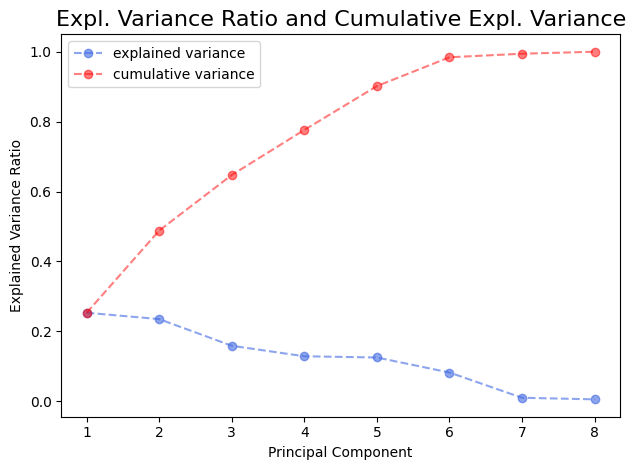

In [47]:
# Explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio:\n {explained_variance}")

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)
print(f"\nCumulative Explained Variance:\n {cumulative_explained_variance}")

# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance) + 1), explained_variance, color='royalblue', marker='o', linestyle='--', alpha=0.6, label="explained variance")
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='red', marker='o', linestyle='--', alpha=0.5, label="cumulative variance")
plt.title('Expl. Variance Ratio and Cumulative Expl. Variance', fontsize=16)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.tight_layout()
plt.legend()
plt.show()

In [48]:
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x_orig)

# Perform PCA on the normalized data
pca_normalized = PCA(n_components=2)
x_pca_normalized = pca_normalized.fit_transform(x_normalized)

In [ ]:
# Plot the normalized PCA results
plt.figure(figsize=(12, 6))

# Subplot 1: Standardized PCA
plt.subplot(1, 2, 1)
sns.kdeplot(x=x_pca_standardized[:, 0], y=x_pca_standardized[:, 1], cmap='viridis', n_levels=15, fill=True)
plt.title('PCA with Standardization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.ylim(-5, 5)
plt.xlim(-5, 5)

# Subplot 2: Normalized PCA
plt.subplot(1, 2, 2)
sns.kdeplot(x=x_pca_normalized[:, 0], y=x_pca_normalized[:, 1], cmap='viridis', n_levels=15, fill=True)
plt.title('PCA with Normalization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

**Standardization vs Normalization**
- Standardization: Centers the data (mean = 0) and scales it to have unit variance (std = 1). Useful for PCA when the data contains features with different scales but similar distributions.

- Normalization: Rescales each feature to a range (usually [0, 1]) or divides each sample by its norm (magnitude), making it useful when feature magnitudes vary widely, or when applying PCA to sparse or skewed data.

**What it means for PCA**
- Standardized PCA: Principal components capture variance by focusing on features with high variance relative to their scale.

- Normalized PCA: Each feature contributes more evenly to the principal components, which can help when the dataset contains features with very different units or distributions.

In [ ]:
pd.DataFrame(x, columns=data.data.columns).describe().T

In [ ]:
pd.DataFrame(x_normalized, columns=data.data.columns).describe().T

### When Standardization is Better (PCA or Linear Regression)  
Dataset with features like house size (in m²), number of rooms, and house age (in years). Features have very different scales.

PCA and linear regression rely on variance and assume the data is normally distributed. Standardization ensures that all features have equal importance by centering them around zero and scaling them to unit variance. Without standardization, the feature with large range will dominate the analysis, overshadowing other important features.

### When Normalization is Better (KNN or Neural Networks)  
Image dataset where pixel intensities range from **0 to 255**. You want to train a neural network to classify the images.  

Neural networks are sensitive to the scale of the input data. Normalizing pixel intensities to a fixed range (e.g., [0, 1]) speeds up convergence during training and reduces the chance of exploding gradients.  
In K-Nearest Neighbors (KNN), normalization ensures that no feature (e.g., pixel brightness) dominates the distance calculation due to its larger magnitude.

### **In Short**  
- **Standardization** → PCA, linear regression, logistic regression, SVM  
- **Normalization** → Neural networks, KNN, image processing, clustering

## Non-linear embedding (UMAP)

Uniform Manifold Approximation and Projection (UMAP) is a powerful dimensionality reduction technique designed to preserve the structure of high-dimensional data when projecting it to lower dimensions. It excels at maintaining both local and global relationships, making it particularly useful for visualizing complex datasets in 2D or 3D. Unlike PCA, UMAP is non-linear and can capture non-Euclidean structures in data. It’s widely used for tasks like clustering, visualization, and preprocessing for machine learning models. Key parameters, such as the number of neighbors (`n_neighbors`) and minimum distance (`min_dist`), allow fine-tuning the balance between local detail and global structure.

In [ ]:
%%time
# Let's generate 2D and 3D umap embeddings of the data
# Generate UMAP embeddings
umap_2d = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
umap_3d = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1)

x_umap_2d = umap_2d.fit_transform(x)
x_umap_3d = umap_3d.fit_transform(x)

print(x_umap_2d.shape, x_umap_3d.shape)

**Note:** The code above is not the same as doing:  
```python
umap_3d = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1)  
umap_2d = umap_3d[:, :2]  
```

Unlike PCA, UMAP does not guarantee that the first two components of a 3D projection will provide the same result as running UMAP directly with `n_components=2`. Each dimensionality reduction is optimized separately and may capture different structures in the data.

In [ ]:
# Plot 2D UMAP representation
plt.scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=y_orig, cmap='viridis', s=15, alpha=0.8)
plt.colorbar(label="Median House Value")
plt.title("UMAP 2D Projection")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

In [ ]:
%%time

sns.kdeplot(x=x_umap_2d[:, 0], y=x_umap_2d[:, 1], cmap='viridis', n_levels=15, fill=True)
plt.title("UMAP 2D Projection")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go

# 3D UMAP representation
fig = go.Figure(
    data=go.Scatter3d(
        x=x_umap_3d[:, 0], y=x_umap_3d[:, 1], z=x_umap_3d[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=y_orig,  # Color by median house value
            colorscale='Viridis',
            opacity=0.7,
            colorbar=dict(title="Median House Value")
        )
    )
)

fig.update_layout(
    title="UMAP 3D Projection",
    scene=dict(
        xaxis_title="UMAP Component 1",
        yaxis_title="UMAP Component 2",
        zaxis_title="UMAP Component 3"
    ),
    width=1000, height=800
)
fig.show()

#### UMAP n_neighbors parameter
The **number of neighbors** in UMAP controls the balance between local and global data structure. Smaller values (e.g. 3-15) focus on preserving local patterns, capturing fine-grained relationships between nearby data points. This is useful for detecting clusters or localized features. Larger values (e.g., 30-50) prioritize global structure, offering a broader view of the data by considering more distant neighbors. While this may blur some local details, it helps reveal overarching trends and relationships in the dataset. The choice of `n_neighbors` should depend on whether you are interested in local or global patterns in the data.

In [ ]:
%%time
# Let's experiment with it using 3, 10, 30, 50, 100, and 300 neighbors.

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, n_neighbors in enumerate(tqdm([3, 10, 30, 50, 100, 300])):
    ax_idx_x = i//3
    ax_idx_y = i%3
    umap_2d = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1)
    x_umap_2d = umap_2d.fit_transform(x)
    sns.scatterplot(x=x_umap_2d[:, 0], y=x_umap_2d[:, 1], hue=y, ax=axes[ax_idx_x, ax_idx_y])

    if i > 0:
        axes[ax_idx_x, ax_idx_y].get_legend().remove() # this hides the legend for all but the first plot

    axes[ax_idx_x, ax_idx_y].set_title(f'n_neighbors={n_neighbors}')

plt.tight_layout()
plt.show()

## Clustering

To further analyze the data, we can apply clustering methods to group similar points based on their proximity in the original and in the UMAP space.

As with any method we need a way to evaluate the quality. For clustering we can use the silhouette score.
The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
is is defined as follows:

$$s(p) = \frac{b(p) - a(p)}{max(a(p), b(p))}$$

where:
* $a(p)$ is the average distance of p to all other points in the *same* cluster
* $b(p)$ is the average distance of p to all other points in the *closest* cluster
* $s(p)$ is the silhouette score of p
* $max(a(p), b(p))$ is the maximum of $a(p)$ and $b(p)$

The silhouette can be interpreted as follows:
* $s(p)$ is between -1 and 1
* $s(p)$ is close to 1 if $a(p) << b(p)$, i.e. the point is well clustered
* $s(p)$ is close to 0 if $a(p) \approx b(p)$, i.e. the point is on the border of the cluster
* $s(p)$ is close to -1 if $a(p) >> b(p)$, i.e. the point is in the wrong cluster

### KMeans

The basic idea:

(from https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)

<img src="https://dashee87.github.io/images/kmeans.gif" alt="k-means in action (x marks the spot of the cluster centroid)" width="50%"/><br>

In [ ]:
# KMeans Clustering on the Original Data with Evaluation Metrics

n_clusters_arr = np.arange(2, 11)
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

for n_clusters in tqdm(n_clusters_arr):
    # Set color palette for clusters
    cm = plt.colormaps['tab20b']
    colors = cm(np.linspace(0, 1, n_clusters))
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=500, random_state=42)
    cluster_labels = kmeans.fit_predict(x)
    centroids = kmeans.cluster_centers_

    silhouette_vals = silhouette_samples(x, cluster_labels)
    mean_silhouette_score = np.mean(silhouette_vals)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Silhouette Plot
    y_lower = 0
    spacing = int(len(x) / 20)
    for i in range(n_clusters):
        cluster_vals = silhouette_vals[cluster_labels == i]
        cluster_vals.sort()

        y_upper = y_lower + len(cluster_vals)
        axes[0].barh(
            range(y_lower, y_upper), cluster_vals, height=1.0, linewidth=0, label=f'Cluster {i}'
        )
        cluster_mean = np.mean(cluster_vals)
        axes[0].text(0.1, (y_lower + y_upper) / 2, f'{cluster_mean:.3f}', ha='center', va='center')
        y_lower = y_upper + spacing

    axes[0].axvline(x=mean_silhouette_score, color='red', linestyle='--')
    axes[0].set_xlabel('Silhouette Score')
    axes[0].set_ylabel('Samples/Cluster')
    axes[0].set_xlim([-0.1, 1])
    axes[0].set_title('Silhouette Plot')
    axes[0].legend(loc='best')

    # UMAP Scatter Plot with Cluster Centroids
    axes[1].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=cluster_labels, alpha=0.1, cmap=cm)
    centroids_umap = umap_2d.transform(centroids)
    axes[1].scatter(centroids_umap[:, 0], centroids_umap[:, 1], c='red', s=100, marker='x', label='Centroids')
    axes[1].set_title('UMAP with Cluster Centroids')
    axes[1].legend()

    plt.suptitle(
        f'{n_clusters} Clusters | Mean Silhouette: {mean_silhouette_score:.3f} | '
        f'Silhouette Score: {silhouette_score(x, cluster_labels):.3f} | '
        f'Calinski-Harabasz: {calinski_harabasz_score(x, cluster_labels):.3f} | '
        f'Davies-Bouldin: {davies_bouldin_score(x, cluster_labels):.3f}'
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Store evaluation metrics
    silhouette_scores.append(silhouette_score(x, cluster_labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(x, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(x, cluster_labels))

# Plot Evaluation Metrics for Different Cluster Numbers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(n_clusters_arr, silhouette_scores, marker='o')
axes[0].set(xlabel='Number of Clusters', ylabel='Score', title='Silhouette Score', ylim=[-0.1, 1])

axes[1].plot(n_clusters_arr, calinski_harabasz_scores, marker='o')
axes[1].set(xlabel='Number of Clusters', title='Calinski-Harabasz Score')

axes[2].plot(n_clusters_arr, davies_bouldin_scores, marker='o')
axes[2].set(xlabel='Number of Clusters', title='Davies-Bouldin Score')

plt.tight_layout()
plt.show()

Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation), higher is better.

Calinski Harabasz score is a measure of how dense the clusters are, higher is better.

Davies Bouldin score is a measure of how similar the clusters are, lower is better.

In [ ]:
# KMeans Clustering on the UMAP embeddings with Evaluation Metrics

n_clusters_arr = np.arange(2, 11)
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

for n_clusters in tqdm(n_clusters_arr):
    # Set color palette for clusters
    cm = plt.colormaps['tab20b']
    colors = cm(np.linspace(0, 1, n_clusters))
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=500, random_state=42)
    cluster_labels = kmeans.fit_predict(x_umap_2d)
    centroids = kmeans.cluster_centers_

    silhouette_vals = silhouette_samples(x_umap_2d, cluster_labels)
    mean_silhouette_score = np.mean(silhouette_vals)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Silhouette Plot
    y_lower = 0
    spacing = int(len(x_umap_2d) / 20)
    for i in range(n_clusters):
        cluster_vals = silhouette_vals[cluster_labels == i]
        cluster_vals.sort()

        y_upper = y_lower + len(cluster_vals)
        axes[0].barh(
            range(y_lower, y_upper), cluster_vals, height=1.0, linewidth=0, label=f'Cluster {i}'
        )
        cluster_mean = np.mean(cluster_vals)
        axes[0].text(0.1, (y_lower + y_upper) / 2, f'{cluster_mean:.3f}', ha='center', va='center')
        y_lower = y_upper + spacing

    axes[0].axvline(x=mean_silhouette_score, color='red', linestyle='--')
    axes[0].set_xlabel('Silhouette Score')
    axes[0].set_ylabel('Samples/Cluster')
    axes[0].set_xlim([-0.1, 1])
    axes[0].set_title('Silhouette Plot')
    axes[0].legend(loc='best')

    # UMAP Scatter Plot with Cluster Centroids
    axes[1].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=cluster_labels, alpha=0.1, cmap=cm)
    axes[1].scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x', label='Centroids')
    axes[1].set_title('UMAP with Cluster Centroids')
    axes[1].legend()

    plt.suptitle(
        f'{n_clusters} Clusters | Mean Silhouette: {mean_silhouette_score:.3f} | '
        f'Silhouette Score: {silhouette_score(x, cluster_labels):.3f} | '
        f'Calinski-Harabasz: {calinski_harabasz_score(x, cluster_labels):.3f} | '
        f'Davies-Bouldin: {davies_bouldin_score(x, cluster_labels):.3f}'
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Store evaluation metrics
    silhouette_scores.append(silhouette_score(x, cluster_labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(x, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(x, cluster_labels))

# Plot Evaluation Metrics for Different Cluster Numbers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(n_clusters_arr, silhouette_scores, marker='o')
axes[0].set(xlabel='Number of Clusters', ylabel='Score', title='Silhouette Score', ylim=[-0.1, 1])

axes[1].plot(n_clusters_arr, calinski_harabasz_scores, marker='o')
axes[1].set(xlabel='Number of Clusters', title='Calinski-Harabasz Score')

axes[2].plot(n_clusters_arr, davies_bouldin_scores, marker='o')
axes[2].set(xlabel='Number of Clusters', title='Davies-Bouldin Score')

plt.tight_layout()
plt.show()

### HDBSCAN

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is an advanced clustering algorithm that builds on DBSCAN, focusing on identifying clusters of varying densities. Unlike KMeans, it doesn't require specifying the number of clusters beforehand and can detect noise (outliers) in the data. HDBSCAN works particularly well for complex datasets where clusters may have irregular shapes or different densities. It constructs a hierarchy of clusters and uses a stability-based approach to select the most meaningful ones. This makes it a robust option for applications like text embeddings or UMAP-reduced data, where traditional clustering methods might struggle.

In [ ]:
%%time
# Perform clustering using HDBSCAN on the UMAP-reduced data
hdb = HDBSCAN(min_cluster_size=10, n_jobs=2)
classes_hdb = hdb.fit_predict(x_umap_2d)

# Determine the number of clusters (unique labels)
n_clusters = len(np.unique(classes_hdb))

cm = plt.colormaps['tab20b']
colors = cm(np.linspace(0, 1, n_clusters))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

# Compute silhouette values for the UMAP-reduced data
silhouette_values = silhouette_samples(x_umap_2d, classes_hdb)

fig, ax = plt.subplots(1,2,figsize=(15,5))

n_points = len(x_umap_2d)
cluster_y_min = 0
ofs = int(n_points / 20)

for cluster_idx, cluster_class in enumerate(np.unique(classes_hdb)):

    cluster_silhouette_values = silhouette_values[classes_hdb == cluster_class]
    cluster_silhouette_values.sort()

    cluster_size = len(cluster_silhouette_values)
    cluster_y_max = cluster_y_min + cluster_size

    ax[0].barh(range(cluster_y_min, cluster_y_max), cluster_silhouette_values, height=1.0, linewidth=0)
    ax[0].text(-0.05, (cluster_y_min + cluster_y_max) / 2, str(cluster_class), ha='center', va='center')
    cluster_mean_score = np.mean(cluster_silhouette_values)
    ax[0].text(0.1, (cluster_y_min + cluster_y_max) / 2, f'{cluster_mean_score:.3f}', ha='center', va='center')

    cluster_y_min = cluster_y_max + ofs

mean_score = np.mean(silhouette_values)
ax[0].axvline(x=mean_score, color='red', linestyle='--')
ax[0].set_title(f'Silhouette score')
ax[0].set_xlabel('Silhouette score')
ax[0].set_ylabel('Sample/Cluster')
ax[0].set_yticks([])
ax[0].set_xlim([-0.1, 1])

# Plot the 2D scatter plot of UMAP-reduced data with HDBSCAN clusters
ax[1].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=classes_hdb, alpha=0.1, cmap='tab20b')
ax[1].set_title('Scatter plot of the UMAPed data with HDBSCAN clusters')

plt.suptitle(f'Silhouette plot for HDBSCAN clusters, mean score: {mean_score:.3f}')
plt.show()

### Gaussian clustering

Gaussian Mixture Models (GMM) are a probabilistic clustering method that assumes the data is generated from a mixture of several Gaussian distributions. Unlike KMeans, which assigns points to the nearest cluster center, GMM provides a **soft clustering approach**: each point is assigned a probability of belonging to each cluster. This makes it more flexible, especially when the clusters have different shapes, sizes, or orientations. GMM is particularly useful when the underlying data distribution is well-modeled by Gaussians, such as in pattern recognition or image segmentation tasks.
Let's make clustering of the umapped data.

In [ ]:
# Perform GMM clustering on UMAP-reduced data for a range of cluster sizes (2 to 10)

n_clusters_arr = np.arange(2, 11)
s_s_arr, ch_s_arr, db_s_arr = [], [], []  # Lists to store silhouette, Calinski-Harabasz, and Davies-Bouldin scores

for n_clusters in tqdm(n_clusters_arr):

    cm = plt.colormaps['tab20b']
    colors = cm(np.linspace(0, 1, n_clusters))
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

    # Fit a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, n_init=10, max_iter=500)
    gmm.fit(x_umap_2d)
    classes = gmm.predict(x_umap_2d)
    probabilities = gmm.predict_proba(x_umap_2d)

    # Extract GMM means and covariances
    means = gmm.means_
    covariances = gmm.covariances_

    # Compute silhouette values
    silhouette_values = silhouette_samples(x_umap_2d, classes)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    n_points = len(x_umap_2d)
    cluster_y_min = 0
    ofs = int(n_points / 20)

    for cluster_idx, cluster_class in enumerate(np.unique(classes)):
        cluster_silhouette_values = silhouette_values[classes == cluster_class]
        cluster_silhouette_values.sort()

        cluster_size = len(cluster_silhouette_values)
        cluster_y_max = cluster_y_min + cluster_size

        ax[0].barh(range(cluster_y_min, cluster_y_max), cluster_silhouette_values, height=1.0, linewidth=0)
        ax[0].text(-0.05, (cluster_y_min + cluster_y_max) / 2, str(cluster_idx), ha='center', va='center')
        cluster_mean_score = np.mean(cluster_silhouette_values)
        ax[0].text(0.1, (cluster_y_min + cluster_y_max) / 2, f'{cluster_mean_score:.3f}', ha='center', va='center')

        cluster_y_min = cluster_y_max + ofs

    mean_score = np.mean(silhouette_values)
    ax[0].axvline(x=mean_score, color='red', linestyle='--')
    ax[0].set_title('Silhouette Score')
    ax[0].set_xlabel('Silhouette Score')
    ax[0].set_ylabel('Sample/Cluster')
    ax[0].set_yticks([])
    ax[0].set_xlim([-0.1, 1])

    ax[1].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=classes, alpha=0.1, cmap=cm)
    ax[1].scatter(means[:, 0], means[:, 1], c='red', s=100, marker='x')  # Mark the centroids
    ax[1].set_title('2D Scatter Plot of UMAP Data with Centroids')

    plt.suptitle(f'Silhouette Plot for {n_clusters} Clusters, Mean Score: {mean_score:.3f}')
    plt.tight_layout()
    plt.show()

    s_s = silhouette_score(x, classes)
    ch_s = calinski_harabasz_score(x, classes)
    db_s = davies_bouldin_score(x, classes)

    s_s_arr.append(s_s)
    ch_s_arr.append(ch_s)
    db_s_arr.append(db_s)

    fig, ax = plt.subplots(1, n_clusters, figsize=(4 * n_clusters, 4))
    cnorm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = 'viridis'

    for i in range(n_clusters):
        ax[i].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=cnorm(probabilities[:, i]), cmap=cmap, alpha=0.1)
        ax[i].set(xlabel='UMAP 1', ylabel='UMAP 2', title=f'Cluster {i}')

    sm = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Probability', fraction=0.05)
    #plt.tight_layout()
    plt.show()

# Plot the evaluation scores (silhouette, Calinski-Harabasz, Davies-Bouldin) across the cluster range
fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))
ax[0].plot(n_clusters_arr, s_s_arr)
ax[0].set(xlabel='Number of Clusters', ylabel='Score', title='Silhouette Score', ylim=[-0.1, 1])
ax[1].plot(n_clusters_arr, ch_s_arr)
ax[1].set(xlabel='Number of Clusters', title='Calinski-Harabasz Score')
ax[2].plot(n_clusters_arr, db_s_arr)
ax[2].set(xlabel='Number of Clusters', title='Davies-Bouldin Score')
plt.tight_layout()
plt.show()

### Inspect for each class

In [ ]:
xy = np.concatenate((x, y.reshape(-1, 1), classes_hdb.reshape(-1, 1)), axis=1)
print(xy.shape)

df = pd.DataFrame(xy, columns=data.feature_names + data.target_names + ['class_hdbscan'])
df.head()

In [ ]:
%%time
# The PairGrid with KDE plots can be slow due to the large dataset size.
# To speed up the process, we will subsample the data to 10% of its original size.
df_sub = df.sample(frac=0.1)
print(f"Subsampled dataset shape: {df_sub.shape}")

# Create a PairGrid with 'class_hdbscan' as the hue (target variable)
g = sns.PairGrid(df_sub, hue='class_hdbscan')

# **Upper Triangle: KDE Plot**
# We use a KDE (Kernel Density Estimate) plot on the upper triangle to visualize the distribution
# of the data in each pair of features. Set the number of contour levels to 10.
g.map_upper(sns.kdeplot, n_levels=10)

# **Lower Triangle: Scatter Plot with Regression Line**
# In the lower triangle, we overlay:
# 1. A scatter plot (blue) with low opacity (5%) and small marker size
# 2. A regression line (red) with low opacity to complement the scatter plot
g.map_lower(sns.regplot,
            scatter_kws={'color': 'blue', 'alpha': 0.1, 's': 15},
            line_kws={'color': 'red', 'alpha': 0.3})

# **Diagonal: Histogram**
# On the diagonal, we plot histograms of each feature, stacked for better visualization
g.map_diag(sns.histplot, multiple='stack')


### Discrete KMeans:

It's a variation of the traditional KMeans clustering algorithm that is designed to handle categorical or discrete data. Unlike the standard KMeans, which works well with continuous data by minimizing the squared Euclidean distance between points and centroids, discrete KMeans uses a different approach for calculating distances. It typically employs measures like the Hamming distance or other similarity metrics suited for categorical data. The goal remains to partition the data into distinct clusters, but the algorithm adjusts for the unique properties of discrete variables, making it more effective when dealing with categorical features.

In [ ]:
# random categorical data
x_test = np.random.choice(20, (1000, 10))

km = KModes(n_clusters=4, init='Huang', n_init=10, verbose=1, n_jobs=-1, max_iter=500)

clusters = km.fit_predict(x_test)

# Print cluster centroids
print(km.cluster_centroids_)

In [ ]:
df.columns

In [ ]:
# We add a column in the original data such that AveRooms_d = int(AveRooms//0.3) and same for AveBedrms_d, Population_d, and HouseAge_d

df['AveRooms_d'] = (df['AveRooms'] // 0.3).astype(int)
df['AveBedrms_d'] = (df['AveBedrms'] // 0.3).astype(int)
df['Population_d'] = (df['Population'] // 0.3).astype(int)
df['HouseAge_d'] = (df['HouseAge'] // 0.3).astype(int)

In [ ]:
# Discrete KMeans clustering of the original data

x4_d = df[['AveRooms_d', 'AveBedrms_d', 'Population_d', 'HouseAge_d']].values
x4 = df[['AveRooms', 'AveBedrms', 'Population', 'HouseAge']].values

umap_2d = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
x4_umap_2d = umap_2d.fit_transform(x4)

n_clusters_arr = np.arange(2, 6)
costs_arr = []

for n_clusters in n_clusters_arr:
    # Use a more vibrant and distinct palette
    palette = sns.color_palette('hsv', n_clusters)  # or 'Set1', 'tab10', 'Paired'

    km = KModes(n_clusters=n_clusters, init='Huang', n_init=10, verbose=1, n_jobs=-1, max_iter=500)
    clusters = km.fit_predict(x4_d)
    costs_arr.append(km.cost_)

    # Plot the UMAP-transformed data with clusters
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.scatterplot(
        x=x4_umap_2d[:, 0], y=x4_umap_2d[:, 1], hue=clusters, ax=ax,
        s=15, alpha=0.7, palette=palette, legend="full"
    )
    ax.set_title(f'UMAP Scatter Plot with {n_clusters} Clusters')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Plot the cost of clustering
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_arr, costs_arr, marker='o', color='dodgerblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Clustering Cost vs Number of Clusters')
plt.grid(True)
plt.show()
plt.close()

In [ ]:
# You can combine categorical and continuous data in the clustering

x8_d = df[['AveRooms_d', 'AveBedrms_d', 'Population_d', 'HouseAge_d', 'MedInc', 'AveOccup', 'Latitude', 'Longitude']].values
cat_cols = [0, 1, 2, 3]
x8 = df[['AveRooms', 'AveBedrms', 'Population', 'HouseAge']].values

umap_2d = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
x8_umap_2d = umap_2d.fit_transform(x8)


n_clusters_arr = np.arange(2, 11)
costs_arr = []

for n_clusters in n_clusters_arr:
    palette = sns.color_palette('hsv', n_clusters)

    km = KPrototypes(n_clusters=n_clusters, init='Huang', n_init=10, verbose=1, n_jobs=-1, max_iter=500)

    clusters = km.fit_predict(x8_d, categorical=cat_cols)
    costs_arr.append(km.cost_)

    # plot the umap_2d data with the classes
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.scatterplot(x=x8_umap_2d[:, 0], y=x8_umap_2d[:, 1], hue=clusters, ax=ax, s=10, alpha=0.1, palette=palette)
    ax.set_title(f'Scatter plot of the UMAPed data with {n_clusters} clusters')
    plt.show()

plt.plot(n_clusters_arr, costs_arr)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Cost of clustering')
plt.show()
plt.close()

# Step 1: Data Normalization

We briefly discussed the importance of data normalization in the previous chapter.

The main reasons for data normalization are:
* to make the data more suitable for the model (e.g. neural networks have better convergence properties if the data normalization is compatible with the parameter initialization)
* to deal with outliers, skewed distributions, and non-linear relationships
* to prevent the model from being biased towards some features
* to prevent the model from learnign wrong relationships between features due to improper data representation

We are going to look at the most standard data preprocessing/normalization techniques:
* StandardScaler
* MinMaxScaler
* RobustScaler
* PowerTransformer

* LabelEncoder
* OrdinalEncoder
* OneHotEncoder

Which of these do you already know?

## Сontinuous data

In [ ]:
cols = ['AveRooms', 'Longitude', 'MedHouseVal']
xy = np.concatenate((x_orig, y_orig.reshape(-1, 1)), axis=1)
df_sel = pd.DataFrame(xy, columns=data.feature_names + data.target_names)
df_sel = df_sel[cols]

v1, v2, v3 = df_sel.values.T

g = sns.PairGrid(df_sel)
g.map_upper(sns.kdeplot, n_levels=10)
g.map_lower(sns.regplot, scatter_kws={'color': 'blue', 'alpha': 0.1, 's': 15}, line_kws={'color': 'red', 'alpha': 0.3})
g.map_diag(sns.histplot, multiple='stack')

In [ ]:
# For each variable, we perform normalization and plot the distribution (upper row) and the log distribution (lower row)

norms = [StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer]
norms_names = [ 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 'PowerTransformer']

n_norms = len(norms)
for v, ttl in zip([v1, v2, v3], cols):
    fig, ax = plt.subplots(2, 1 + n_norms, figsize=(15, 4))

    for j in range(2):
        ax_ji = ax[j, 0]
        sns.histplot(v, ax=ax_ji, alpha=0.3)

        moments = [v.mean(), v.var(), skew(v), kurtosis(v)]
        moments_str = ', '.join([f'{moment:.3f}' for moment, moment_name in zip(moments, ['mean', 'var', 'skew', 'kurt'])])
        ax_ji.set_title(f'original data\n{moments_str}')

        if j==1:
            ax_ji.set_yscale('log')

        for i, (norm, norm_name) in enumerate(zip(norms, norms_names)):
            v_norm = norm().fit_transform(v.reshape(-1, 1)).reshape(-1)

            # get all first 4 moments of the distribution
            moments = [v_norm.mean(), v_norm.var(), skew(v_norm), kurtosis(v_norm)]
            moments_str = ', '.join([f'{moment:.3f}' for moment, moment_name in zip(moments, ['mean', 'var', 'skew', 'kurt'])])

            ax_ji = ax[j, 1 + i]
            sns.histplot(v_norm, ax=ax_ji, alpha=0.3)
            ax_ji.set_title(f'{norm_name}\n{moments_str}')
            if j == 1:
                ax_ji.set_yscale('log')

    plt.suptitle(ttl)
    plt.tight_layout(h_pad=2)
    plt.show()

As you see the robust scaler is the most robust to outliers, but it's not the best for the other distributions.
The power transformer is the best to make data normally distributed, but it's not always producing the best results.

## Categorical data

In [ ]:
# make dummy dataframe with categorical data:
# color: red, green, blue
# size: small, medium, large
# shape: round, square, triangle, parallelogram, diamond
# fill with random values out of the categories, 100 rows

n = 100
df_cat = pd.DataFrame({
    'color': np.random.choice(['red', 'green', 'blue'], n),
    'size': np.random.choice([1, 10, 100], n),
    'shape': np.random.choice(['round', 'square', 'triangle', 'parallelogram', 'diamond'], n)
})


n_norms = len(norms)

for col in df_cat.columns:
    df_col = df_cat[[col]]

    normed_vals = LabelEncoder().fit_transform(df_col[col].values)  # output is integer, single column
    df_col[f'{col}_LabelEncoder'] = normed_vals

    # ensure that the categories are sorted
    categories = sorted(np.unique(df_col[col]))
    # output is float(integer), multiple columns at a time
    normed_vals = OrdinalEncoder(categories=[categories]).fit_transform(df_col[col].values.reshape(-1, 1))
    df_col[f'{col}_OrdinalEncoder'] = normed_vals.reshape(-1)

    normed_vals = OneHotEncoder(sparse_output=False, drop='first').fit_transform(df_col[col].values.reshape(-1, 1))
    df_col[f'{col}_OneHotEncoder'] = [str(normed_vals_i) for normed_vals_i in normed_vals]


    print(f'\ncol={col}')
    print(df_col.head(10))


So we can see that the OrdinalEncoder is suitable for the size column, as it's naturally ordered.
For advanced models label encoding can only be ised if the categories are used as tokens, otherwise it's better to use one hot encoding

The one hot can be always used, but it increases the onumber of colums substantially, so it's not always the best choice.
To prevent linearly dependent columns, we can use the `drop` parameter, which drops the first column of each category, so we have `n-1` columns for `n` categories.

# Step 2: Data Imputation

Data imputation is the process of replacing missing data with substituted values.
You often have to deal with missing data, either because the data is not available, or because it's not applicable, or because it's not recorded.

## Ouliers

In [ ]:
ecod = ECOD(n_jobs=-1, contamination=0.1)
ecod.fit(x)
df['outlier'] = ecod.predict(x)

In [ ]:
df['outlier'].value_counts()

In [ ]:
# make a scatter plot of the umap_2d data with the outliers
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

cm = plt.get_cmap('tab20c', 2)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.colors)
sns.scatterplot(x=x_umap_2d[:, 0], y=x_umap_2d[:, 1], hue=df['outlier'], ax=ax, s=10, alpha=0.8);

## Missing data

There several methods of dealing with missing data. The most important is to understand the nature of the missing data:
* is it missing completely at random (MCAR) - independent of the observed and missing data
* is it missing at random (MAR) - dependent on the observed data but independent of the missing data
* is it missing not at random (MNAR) - dependent on the missing data



 [Summary-of-methods-for-handling-missing-values-in-data-instances](https://www.researchgate.net/figure/Summary-of-methods-for-handling-missing-values-in-data-instances-259_fig12_313510665)


<img src="https://github.com/dsl-unibe-ch/Advanced_ML_with_scikit-learn/raw/main/fig_imputation.png" alt="fig_imputation" width="50%"/><br>

In [ ]:
# make a copy of the original data
df_imp = df.copy()

In [ ]:
xy = np.concatenate((x, y.reshape(-1, 1)), axis=1)
print(xy.shape)
df_imp = pd.DataFrame(xy, columns=data.feature_names + data.target_names)

In [ ]:
# make some missing values in the data
df_imp.loc[df_imp.sample(frac=0.5).index, 'AveRooms'] = np.nan

In [ ]:
df_imp.isna().mean()

In [ ]:
# We now impute the missing values with the mean
imp = SimpleImputer(strategy='mean')  # strategy can be 'mean', 'median', 'most_frequent', 'constant' (according to `fill_value`)

df_imp['AveRooms_imp'] = imp.fit_transform(df_imp[['AveRooms']])


In [ ]:
# Distribution plot of the original and imputed data

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

bins=np.linspace(-10, 30, 40)
# alpha is .3 to make the plot more transparent, log scale to see the small values
sns.histplot(df['AveRooms'], ax=ax, label='Original', alpha=0.3, color='red', bins=bins)
sns.histplot(df_imp['AveRooms_imp'], ax=ax, label='Imputed', alpha=0.3, color='blue', bins=bins)
ax.set_yscale('log')

In [ ]:
df_imp.columns

In [ ]:
knn = KNNImputer(n_neighbors=5)

imp_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
df_imp['AveRooms_imp_knn'] = knn.fit_transform(df_imp[imp_cols])[:, 2]

sns.histplot(df_imp['AveRooms_imp_knn'][df_imp['AveRooms'].isna()], label='Imputed KNN', alpha=0.3);

In [ ]:
# Distribution plot of the original and imputed data

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

bins=np.linspace(-10, 30, 40)
# alpha is .3 to make the plot more transparent, log scale to see the small values
sns.histplot(df['AveRooms'], ax=ax, label='Original', alpha=0.3, color='red', bins=bins)
# sns.histplot(df_imp['AveRooms_imp'], ax=ax, label='Imputed', alpha=0.3, color='blue', bins=bins)
sns.histplot(df_imp['AveRooms_imp_knn'], ax=ax, label='Imputed KNN', alpha=0.3, color='green', bins=bins)
ax.set_yscale('log')

In [ ]:
# Iterative imputer of the data:
# Multivariate imputer that estimates each feature from all the others.
imp = IterativeImputer()

df_imp['AveRooms_imp_iter'] = imp.fit_transform(df_imp[imp_cols])[:, 2]
sns.histplot(df_imp['AveRooms_imp_iter'][df_imp['AveRooms'].isna()], label='Imputed regression', alpha=0.3);

In [ ]:
# Distribution plot of the original and imputed data

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

bins=np.linspace(-10, 30, 40)
# alpha is .3 to make the plot more transparent, log scale to see the small values
sns.histplot(df['AveRooms'], ax=ax, label='Original', alpha=0.3, color='red', bins=bins)
#sns.histplot(df_imp['AveRooms_imp'], ax=ax, label='Imputed', alpha=0.3, color='blue', bins=bins)
#sns.histplot(df_imp['AveRooms_imp_knn'], ax=ax, label='Imputed KNN', alpha=0.3, color='green', bins=bins)
sns.histplot(df_imp['AveRooms_imp_iter'], ax=ax, label='Imputed Iter', alpha=0.3, color='yellow', bins=bins)
ax.set_yscale('log')

In [ ]:
# np.float = np.float64  # might be needed for new np for impyute to run

In [ ]:
df_imp['AveRooms_imp_mice'] = mice(df_imp[imp_cols].values)[:, 2]

sns.histplot(df_imp['AveRooms_imp_mice'][df_imp['AveRooms'].isna()], label='Imputed MICE', alpha=0.3);

In [ ]:
# Distribution plot of the original and imputed data

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

bins=np.linspace(-10, 30, 40)
# alpha is .3 to make the plot more transparent, log scale to see the small values
sns.histplot(df['AveRooms'], ax=ax, label='Original', alpha=0.3, color='red', bins=bins)
#sns.histplot(df_imp['AveRooms_imp'], ax=ax, label='Imputed', alpha=0.3, color='blue', bins=bins)
#sns.histplot(df_imp['AveRooms_imp_knn'], ax=ax, label='Imputed KNN', alpha=0.3, color='green', bins=bins)
sns.histplot(df_imp['AveRooms_imp_iter'], ax=ax, label='Imputed Iter', alpha=0.3, color='yellow', bins=bins)
sns.histplot(df_imp['AveRooms_imp_mice'][df_imp['AveRooms'].isna()], label='Imputed MICE', alpha=0.3, color='purple', bins=bins)
ax.set_yscale('log')

Please explore the other imputation methods in the `impyute` library.
There is a number of them for different types of data.

# Step 3. Data Transformation Pipeline

We see by now that we have a number of preprocessing steps even before we start fitting the model. To simplify our work we can use the `Pipeline` class from `sklearn.pipeline` module.

The aim of a pipeline is to assemble several preprocessing steps and a model in a single object.

In [ ]:
data = fetch_california_housing()
x, y = data.data, data.target

col_names = data.feature_names
tgt_names = data.target_names

xy = np.concatenate((x, y.reshape(-1, 1)), axis=1)

df = pd.DataFrame(xy, columns=col_names + tgt_names)

In [ ]:
# 'Longitude', 'Latitude', 'HouseAge' - MinMaxScaler
# 'Population', 'AveOccup', 'AveRooms', 'AveBedrms', 'MedInc' - PowerTransformer

# standardize the target
pipeline_min_max = Pipeline([
    ('min_max_scaler', MinMaxScaler())
])

pipeline_power = Pipeline([
    ('power_transformer', PowerTransformer())
])


pipeline_preproc = ColumnTransformer([
    ('min_max_scaler', pipeline_min_max, ['Longitude', ]),
    ('power_transformer', pipeline_power, ['Population', ]),
],
    remainder='passthrough')


In [ ]:
pipeline_preproc.fit(df)
df_preproc =  pd.DataFrame(pipeline_preproc.transform(df), columns=pipeline_preproc.get_feature_names_out())

In [ ]:
df_preproc

we can expand the pipeline to impute the missing values with the MICE method.

In [ ]:
pipeline_impute = Pipeline([
    ('mice_imputer', mice)
])

pipeline_preproc = ColumnTransformer([
    ('min_max_scaler', pipeline_min_max, ['Longitude', 'Latitude', 'HouseAge']),
    ('power_transformer', pipeline_power, ['Population', 'AveOccup', 'AveRooms', 'AveBedrms', 'MedInc']),
],
    remainder='passthrough')

pipeline = Pipeline([
    ('preproc', pipeline_preproc),
    ('impute', pipeline_impute),
    ('pass', 'passthrough')
])

pipeline.fit(df)
df_preproc =  pd.DataFrame(pipeline.transform(df), columns=pipeline.get_feature_names_out())
df_preproc.head()

In [ ]:
# we need a custom function to make the pipeline work with the mice imputer function

def mice_imputer(data_x):
    if np.isnan(data_x).any():
        return mice(data_x)
    else:
        return data_x

pipeline_impute = Pipeline([
    ('mice_imputer', FunctionTransformer(mice_imputer))
])

pipeline = Pipeline([
    ('preproc', pipeline_preproc),
    ('impute', pipeline_impute),
    ('pass', 'passthrough')
])

pipeline.fit(df)
df_preproc =  pd.DataFrame(pipeline.transform(df), columns=pipeline_preproc.get_feature_names_out())
df_preproc.head()


In [ ]:
%%time
# finally we can add a model to the pipeline. let's use a random forest regressor

pipeline = Pipeline([
    ('preproc', pipeline_preproc),
    ('impute', pipeline_impute),
    ('model', RandomForestRegressor())
])

tgt_name = tgt_names[0]
df_train, df_test = train_test_split(df, test_size=0.2)
pipeline.fit(df_train[col_names], df_train[tgt_name])

y_pred = pipeline.predict(df_test[col_names])

mse = mean_squared_error(df_test[tgt_name], y_pred)
r2 = r2_score(df_test[tgt_name], y_pred)
print(f'mse={mse:.3f}, r2={r2:.3f}')

# plot the predicted vs true values

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=df_test[tgt_name], y=y_pred, ax=ax, alpha=0.3)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

In [ ]:
%%time
# we can also use the pipeline to do CV and grid search

param_grid = {
    'model__n_estimators': [10, 100, 200, 400],  # ToDo: test if 400 is ok on colab
    'model__max_depth': [1, 20, 100],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=2, n_jobs=2, verbose=2)

grid_search.fit(df_train[col_names], df_train[tgt_name])

In [ ]:
print(grid_search.best_params_)

In [ ]:
grid_search.cv_results_

In [ ]:
res = grid_search.cv_results_
cfgs = [str(p) for p in res['params']]
scores = res['mean_test_score']
scores_std = res['std_test_score']

time = res['mean_fit_time']
time_std = res['std_fit_time']

# Results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.errorbar(cfgs, scores, yerr=scores_std, fmt='o')
ax.set_xticklabels(cfgs, rotation=90)
ax.set_ylabel('mean test score (r2)')
ax.set_xlabel('configurations')
plt.show()


# Time

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.errorbar(cfgs, time, yerr=time_std, fmt='o')
ax.set_xticklabels(cfgs, rotation=90)
ax.set_ylabel('mean fit time, sec')
ax.set_xlabel('configurations')
plt.show()

In [ ]:
y_pred = grid_search.predict(df_test[col_names])

mse = mean_squared_error(df_test[tgt_name], y_pred)
r2 = r2_score(df_test[tgt_name], y_pred)

print(f'mse={mse:.3f}, r2={r2:.3f}')

# plot the predicted vs true values

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=df_test[tgt_name], y=y_pred, ax=ax, alpha=0.3)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

It is not advised to use the pipeline for the metric evaluation, e.g. see the discussion [here](https://stackoverflow.com/questions/43787107/use-a-metric-after-a-classifier-in-a-pipeline)    

# Step 4. Saving and Loading Models

The easiest is to use the `joblib` library, which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted scikit-learn estimators.
Saving the model with simple `pickle` can be problematic, as it can lead to compatibility issues between different Python versions.

In [ ]:
# save the pipeline
dump(pipeline, 'pipeline.joblib')

# load the pipeline
pipeline_loaded = load('pipeline.joblib')

# use the loaded pipeline
y_pred = pipeline_loaded.predict(df_test[col_names])

mse = mean_squared_error(df_test[tgt_name], y_pred)
print(f'mse={mse:.3f}')

# plot the predicted vs true values


# Step 5. Data IO

In [ ]:
# Save the data

# csv is human-readable, but not the most efficient
df.to_csv('california_housing.csv', index=False)

# feather is the most efficient for pandas dataframes
df.to_feather('california_housing.feather')

In [ ]:
# Load the data, testing the time

%timeit df_csv = pd.read_csv('california_housing.csv')
%timeit df_feather = pd.read_feather('california_housing.feather')

In [ ]:
# File sizes

print(f'csv: {os.path.getsize("california_housing.csv") / 1024 / 1024:.3f} MB')
print(f'feather: {os.path.getsize("california_housing.feather") / 1024 / 1024:.3f} MB')

# Step 6. Data Visualization

We will end this course with same message as we started it: the importance of data visualization.
After all, the main goal of the data analysis is to make the data understandable and interpretable.
Once we did all the ML work, we need to present the results in a way that is understandable - to the stakeholders, to the team, to the scientific community, to the public, and most importantly to ourselves.


We can use plotly for interactive plots:


In [ ]:
fig = px.scatter(df, x='AveRooms', y='AveBedrms', color='MedHouseVal', hover_data=['Latitude', 'Longitude'])

In [ ]:
fig

In [ ]:
df['idx'] = df.index
df['pred'] = grid_search.predict(df[col_names])

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash('Houses', external_stylesheets=external_stylesheets)



app.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Dropdown(
                df.columns,
                'AveRooms',
                id='crossfilter-xaxis-column',
            ),
            dcc.RadioItems(
                ['Linear', 'Log'],
                'Linear',
                id='crossfilter-xaxis-type',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ],
        style={'width': '32%', 'float': 'left', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                df.columns,
                'AveBedrms',
                id='crossfilter-yaxis-column'
            ),
            dcc.RadioItems(
                ['Linear', 'Log'],
                'Linear',
                id='crossfilter-yaxis-type',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ], style={'width': '32%', 'float': 'left', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                df.columns,
                'MedHouseVal',
                id='crossfilter-zaxis-column'
            )
        ], style={'width': '32%', 'float': 'left', 'display': 'inline-block'})
    ], style={
        'padding': '10px 5px'
    }),

    html.Div([
        dcc.Graph(
            id='crossfilter-indicator-scatter',
            #hoverData={'points': [{'customdata': None}]},
            selectedData={'points': [{'customdata': None}]}

        )
    ], style={'width': '49%', 'display': 'inline-block', 'padding': '0 20'}),
    html.Div([
        dcc.Graph(id='x-plot'),
        dcc.Graph(id='y-plot'),
    ], style={'display': 'inline-block', 'width': '49%'}),

    html.Div(dcc.Slider(
        df['MedHouseVal'].min(),
        df['MedHouseVal'].max(),
        step=None,
        id='crossfilter-houseval--slider',
        value=df['MedHouseVal'].max(),
        marks={str(v): str(v) for v in range(int(df['MedHouseVal'].max()+1))}
    ), style={'width': '49%', 'padding': '0px 20px 20px 20px'})
])


@callback(
    Output('crossfilter-indicator-scatter', 'figure'),
    Input('crossfilter-xaxis-column', 'value'),
    Input('crossfilter-yaxis-column', 'value'),
    Input('crossfilter-zaxis-column', 'value'),
    Input('crossfilter-xaxis-type', 'value'),
    Input('crossfilter-yaxis-type', 'value'),
    Input('crossfilter-houseval--slider', 'value'))
def update_graph(xaxis_column_name, yaxis_column_name, zaxis_column_name,
                 xaxis_type, yaxis_type,
                 price_value):
    dff = df[df['MedHouseVal'] < price_value]



    fig = px.scatter(x=dff[xaxis_column_name],
                     y=dff[yaxis_column_name],
                     color=dff[zaxis_column_name],
                     hover_name=dff['MedHouseVal']
                     )

    fig.update_traces(customdata=dff['idx'])

    fig.update_xaxes(title=xaxis_column_name, type='linear' if xaxis_type == 'Linear' else 'log')

    fig.update_yaxes(title=yaxis_column_name, type='linear' if yaxis_type == 'Linear' else 'log')

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')

    return fig


def create_plot(dff, axis_type, axis):

    fig = px.scatter(dff, x='MedHouseVal', y=axis)

    fig.update_traces(mode='markers')

    fig.update_xaxes(showgrid=False)

    fig.update_yaxes(type='linear' if axis_type == 'Linear' else 'log')

    fig.add_annotation(x=0, y=0.85, xanchor='left', yanchor='bottom',
                       xref='paper', yref='paper', showarrow=False, align='left',
                       text=axis)

    fig.update_layout(height=225, margin={'l': 20, 'b': 30, 'r': 10, 't': 10})

    return fig


@callback(
    Output('x-plot', 'figure'),
    Input('crossfilter-indicator-scatter', 'selectedData'),
    Input('crossfilter-xaxis-column', 'value'),
    Input('crossfilter-xaxis-type', 'value'))
def update_x_timeseries(hoverData, xaxis_column_name, axis_type):
    idx = [p['customdata'] for p in hoverData['points']]
    idx = [i for i in idx if i is not None]
    dff = df.iloc[idx]
    return create_plot(dff, axis_type, xaxis_column_name)


@callback(
    Output('y-plot', 'figure'),
    Input('crossfilter-indicator-scatter', 'selectedData'),
    Input('crossfilter-yaxis-column', 'value'),
    Input('crossfilter-yaxis-type', 'value'))
def update_y_timeseries(hoverData, yaxis_column_name, axis_type):
    idx = [p['customdata'] for p in hoverData['points']]
    idx = [i for i in idx if i is not None]
    dff = df.iloc[idx]
    return create_plot(dff, axis_type, yaxis_column_name)


app.run(debug=True)


# Workshop

Use your data to exercise the same steps as in the notebook.

Alternatively, you can use the extended house price data: Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf



In [ ]:
# load the data
path = os.path.abspath('.')+'/colab_material.tgz'
url = 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz'

r = requests.get(url)

with open(path, 'wb') as f:
    f.write(r.content)

tar = tarfile.open(path, "r:gz")
tar.extractall()
tar.close()

In [ ]:
path = 'data/AmesHousing.csv'
df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)
rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}  # simplify the column names
df.rename(columns=rename_dict, inplace=True)

In [ ]:
df.head()

# Further reading

* [scikit-learn](https://scikit-learn.org/stable/)
* [Clustering with visualizations](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs)
* [hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)
* [dash](https://dash.plotly.com/)
* [plotly](https://plotly.com/python/)
* [streamlit](https://streamlit.io/)
* [MLFlow](https://mlflow.org/)

# Courses and support at DSL

* [Data Science Lab](https://www.dsl.unibe.ch)
* [Data Science Lab Walk-in](https://www.dsl.unibe.ch/support/walk_in/)